### Part 0 & 1

In [55]:
from torchtext import data, datasets
import torch
from sklearn.model_selection import train_test_split
import random
import numpy as np
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import seaborn as sns

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from collections import defaultdict, Counter
import string

In [57]:
from sklearn.model_selection import KFold

In [58]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True,
    fix_length=50,
    lower=True,
    unk_token='<unk>',
    pad_token='<pad>'
    )

# For multi-class classification labels
LABEL = data.LabelField()

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [59]:
label_set = set()
for i in train_data:
    label_set.add(i.label)

print(label_set)

{'DESC', 'LOC', 'ENTY', 'NUM', 'HUM', 'ABBR'}


In [60]:
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [61]:
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [62]:
embedding_dim = 100
vocab = TEXT.vocab

# Create tensor for nn.Embedding
embedding_matrix_tensor = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.stoi.items():
    if word in embedding_matrix:
        embedding_matrix_tensor[idx] = embedding_matrix[word]

# Create embedding layer (learnable)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False)
print("Embedding layer created with shape:", embedding_layer.weight.shape)


Embedding layer created with shape: torch.Size([8536, 100])


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [64]:
import itertools, copy, pandas as pd


# RNN

### Libraries & Functions

In [65]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
embedding_dim = embedding_layer.weight.size(1)

In [ ]:
# Simple RNN classifier (tanh)
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional, dropout, num_classes):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",      # simple RNN
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, text):
        x = self.embedding(text)                     # [B, T, E]
        outputs, hidden = self.rnn(x)                # hidden: [L*D, B, H]
        if self.rnn.bidirectional:
            last = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]
        else:
            last = hidden[-1]                                   # [B, H]
        return self.fc(self.dropout(last))

In [ ]:
import itertools, copy, random
import numpy as np
import torch
import torch.nn as nn
from torchtext import data
from sklearn.model_selection import KFold

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def build_iters(batch_size, train_data, valid_data, device):
    return data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device):
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes
    ).to(device)
    return model

def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

# K-Fold training function
def train_kfold_config(k_folds, batch_size, lr, hidden_dim, *,
                       num_layers, bidirectional, dropout, num_classes,
                       full_dataset, pad_idx, device, embedding_layer,
                       max_epochs=50, patience=3, seed=42):

    set_seed(seed)  

    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    fold_results = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} =====")

        # Create new Dataset splits
        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        # Build iterators
        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        # Build model, loss, optimizer
        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_val_acc = -1.0
        epochs_no_improve = 0
        best_state = None

        # Train per fold
        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)
        fold_models.append(model)

    mean_acc = np.mean(fold_results)
    print(f"\n===== K-Fold Results =====")
    for i, acc in enumerate(fold_results, 1):
        print(f"Fold {i}: {acc:.4f}")
    print(f"Average Val Accuracy: {mean_acc:.4f}")

    return mean_acc, fold_results, fold_models


## Skip here ownards (10 cells) -- might need to remove

In [13]:
# -----------------------------
# 1. Setup & Config
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume TEXT, LABEL, train_data, test_data, embedding_layer already exist
train_data, valid_data = train_data.split(split_ratio=0.9, random_state=random.seed(SEED))
print(f"Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
embedding_dim = embedding_layer.weight.size(1)

Train: 4416, Valid: 491, Test: 500


In [22]:
# -----------------------------
# Train/eval 1 epoch
# -----------------------------
def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # RNNs can explode
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)


In [ ]:
# -----------------------------
# Grid search with early stopping that SAVES BEST WEIGHTS
# -----------------------------
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
NUM_CLASSES = len(LABEL.vocab)
MAX_EPOCHS = 20
PATIENCE = 3

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

batch_sizes = [32, 64, 128]
learning_rates = [5e-4, 1e-3, 2e-3, 3e-3]

results = []

for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 Testing BATCH={bs}, LR={lr}")
    train_iter, valid_iter = data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=bs,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

    # fresh embedding weights each trial
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=PAD_IDX
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # ---- your early stopping block (with saving best) ----
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())  # keep BEST weights
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping")
                break

    # restore best weights before logging result (so this combo truly reflects its best)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    results.append({"batch_size": bs, "lr": lr, "val_acc": best_val_acc})




🔍 Testing BATCH=32, LR=0.0005
Epoch 01: train_acc=0.6003, val_acc=0.7943
Epoch 02: train_acc=0.8252, val_acc=0.8411
Epoch 03: train_acc=0.8705, val_acc=0.8839
Epoch 04: train_acc=0.9017, val_acc=0.9063
Epoch 05: train_acc=0.9237, val_acc=0.8900
Epoch 06: train_acc=0.9386, val_acc=0.9022
Early stopping

🔍 Testing BATCH=32, LR=0.001
Epoch 01: train_acc=0.6771, val_acc=0.8534
Epoch 02: train_acc=0.8490, val_acc=0.8778
Epoch 03: train_acc=0.8961, val_acc=0.8982
Epoch 04: train_acc=0.9214, val_acc=0.9124
Epoch 05: train_acc=0.9450, val_acc=0.9022
Epoch 06: train_acc=0.9656, val_acc=0.8982
Early stopping

🔍 Testing BATCH=32, LR=0.002
Epoch 01: train_acc=0.7124, val_acc=0.8228
Epoch 02: train_acc=0.8594, val_acc=0.8676
Epoch 03: train_acc=0.9128, val_acc=0.8656
Epoch 04: train_acc=0.9402, val_acc=0.8574
Early stopping

🔍 Testing BATCH=32, LR=0.003
Epoch 01: train_acc=0.7251, val_acc=0.8513
Epoch 02: train_acc=0.8449, val_acc=0.8493
Epoch 03: train_acc=0.9096, val_acc=0.8676
Epoch 04: train_a

NameError: name 'pd' is not defined

In [27]:
df_results = pd.DataFrame(results).sort_values("val_acc", ascending=False)
best = df_results.iloc[0]
print("\n🏆 Best configuration:")
print(best)
print("\nAll results (sorted):\n", df_results.reset_index(drop=True))


🏆 Best configuration:
batch_size    32.000000
lr             0.001000
val_acc        0.912424
Name: 1, dtype: float64

All results (sorted):
     batch_size      lr   val_acc
0           32  0.0010  0.912424
1          128  0.0005  0.910387
2           64  0.0005  0.908350
3           32  0.0005  0.906314
4          128  0.0020  0.902240
5           64  0.0010  0.898167
6          128  0.0010  0.892057
7           64  0.0020  0.892057
8           64  0.0030  0.885947
9           32  0.0030  0.883910
10         128  0.0030  0.881874
11          32  0.0020  0.867617


In [ ]:
# --- 1) Fix best batch size & lr from your previous grid search result `best` ---
best_batch_size = int(best["batch_size"])
best_lr = float(best["lr"])
print(f"\n✅ Using best hyperparams from LR/Batch search -> batch_size={best_batch_size}, lr={best_lr}")

# --- 2) Hidden-dim search using fixed (batch_size, lr) ---

# Search space (tweak as you like)
hidden_dims = [64, 96, 128, 192, 256, 384, 512]

results_hd = []

# Rebuild iterators ONCE with best batch size
train_iter, valid_iter = data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

for hd in hidden_dims:
    print(f"\n🧪 Testing hidden_dim={hd}")

    # fresh embedding weights for each trial
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=PAD_IDX
    )

    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hd,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_val_acc_hd = -1.0
    epochs_no_improve = 0
    best_model_state_hd = None

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # Early stopping + save-best (your pattern)
        if val_acc > best_val_acc_hd:
            best_val_acc_hd = val_acc
            epochs_no_improve = 0
            best_model_state_hd = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping")
                break

    # Restore best for this hidden_dim before recording
    if best_model_state_hd is not None:
        model.load_state_dict(best_model_state_hd)

    results_hd.append({"hidden_dim": hd, "val_acc": best_val_acc_hd})


In [ ]:
# --- 3) Pick best hidden dim, print & save variable ---
df_hd = pd.DataFrame(results_hd).sort_values("val_acc", ascending=False).reset_index(drop=True)
best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])

print("\n🏆 Best hidden_dim configuration:")
print(df_hd.loc[0])
print("\nAll hidden_dim results (sorted):")
print(df_hd)

# Variables now set for subsequent training:
print(f"\n👉 Final choice: best_batch_size={best_batch_size}, best_lr={best_lr}, best_hidden_dim={best_hidden_dim}")

------------------

In [ ]:
import itertools, copy
import torch
import torch.nn as nn
import pandas as pd
from torchtext import data

# -----------------------------
# Generic helpers
# -----------------------------
def build_iters(batch_size, train_data, valid_data, device):
    return data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device):
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes
    ).to(device)
    return model

def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        tot_loss   += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count  += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

def train_one_config(batch_size, lr, hidden_dim, *,
                     num_layers, bidirectional, dropout, num_classes,
                     train_data, valid_data, pad_idx, device,
                     max_epochs=20, patience=3):
    """Train one (batch_size, lr, hidden_dim) with early stopping; return best_val_acc and best_state."""
    train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)
    model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1.0
    epochs_no_improve = 0
    best_state = None

    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
        val_loss,   val_acc   = epoch_run(valid_iter, model, criterion, optimizer=None)
        print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_acc, model


In [30]:
NUM_CLASSES   = len(LABEL.vocab)
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT       = 0.3
MAX_EPOCHS    = 20
PATIENCE      = 3

batch_sizes     = [32, 64, 128]
learning_rates  = [5e-4, 1e-3, 2e-3, 3e-3]
HIDDEN_DIM_FIXED = 128   # fixed while tuning (batch, lr)

results = []
for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 Testing BATCH={bs}, LR={lr}")
    val_acc, _ = train_one_config(
        bs, lr, HIDDEN_DIM_FIXED,
        num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT, num_classes=NUM_CLASSES,
        train_data=train_data, valid_data=valid_data, pad_idx=PAD_IDX, device=device,
        max_epochs=MAX_EPOCHS, patience=PATIENCE
    )
    results.append({"batch_size": bs, "lr": lr, "val_acc": val_acc})

df_results = pd.DataFrame(results).sort_values("val_acc", ascending=False).reset_index(drop=True)
best = df_results.loc[0]
best_batch_size = int(best["batch_size"])
best_lr        = float(best["lr"])
print("\n🏆 Best (batch, lr):")
print(best)
print(f"\nSaved vars -> best_batch_size={best_batch_size}, best_lr={best_lr}")



🔍 Testing BATCH=32, LR=0.0005
Epoch 01: train_acc=0.6187, val_acc=0.8147
Epoch 02: train_acc=0.8102, val_acc=0.8391
Epoch 03: train_acc=0.8718, val_acc=0.8778
Epoch 04: train_acc=0.8981, val_acc=0.9043
Epoch 05: train_acc=0.9167, val_acc=0.8880
Epoch 06: train_acc=0.9366, val_acc=0.9043
Epoch 07: train_acc=0.9545, val_acc=0.8941
Early stopping

🔍 Testing BATCH=32, LR=0.001
Epoch 01: train_acc=0.6769, val_acc=0.8737
Epoch 02: train_acc=0.8406, val_acc=0.8635
Epoch 03: train_acc=0.9051, val_acc=0.8859
Epoch 04: train_acc=0.9282, val_acc=0.9022
Epoch 05: train_acc=0.9452, val_acc=0.8758
Epoch 06: train_acc=0.9654, val_acc=0.8859
Epoch 07: train_acc=0.9758, val_acc=0.8880
Early stopping

🔍 Testing BATCH=32, LR=0.002
Epoch 01: train_acc=0.6791, val_acc=0.8391
Epoch 02: train_acc=0.8576, val_acc=0.8819
Epoch 03: train_acc=0.9092, val_acc=0.8819
Epoch 04: train_acc=0.9466, val_acc=0.8819
Epoch 05: train_acc=0.9558, val_acc=0.9043
Epoch 06: train_acc=0.9817, val_acc=0.8900
Epoch 07: train_acc

In [31]:
hidden_dims = [64, 96, 128, 192, 256, 384, 512]
results_hd = []

for hd in hidden_dims:
    print(f"\n🧪 Testing hidden_dim={hd} (batch={best_batch_size}, lr={best_lr})")
    val_acc, _ = train_one_config(
        best_batch_size, best_lr, hd,
        num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT, num_classes=NUM_CLASSES,
        train_data=train_data, valid_data=valid_data, pad_idx=PAD_IDX, device=device,
        max_epochs=MAX_EPOCHS, patience=PATIENCE
    )
    results_hd.append({"hidden_dim": hd, "val_acc": val_acc})

df_hd = pd.DataFrame(results_hd).sort_values("val_acc", ascending=False).reset_index(drop=True)
best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])
print("\n🏆 Best hidden_dim configuration:")
print(df_hd.loc[0])
print(f"\nSaved var -> best_hidden_dim={best_hidden_dim}")
print("\nAll hidden_dim results:\n", df_hd)



🧪 Testing hidden_dim=64 (batch=128, lr=0.0005)
Epoch 01: train_acc=0.3718, val_acc=0.4847
Epoch 02: train_acc=0.5661, val_acc=0.7006
Epoch 03: train_acc=0.6891, val_acc=0.7780
Epoch 04: train_acc=0.7538, val_acc=0.8086
Epoch 05: train_acc=0.8000, val_acc=0.8411
Epoch 06: train_acc=0.8379, val_acc=0.8554
Epoch 07: train_acc=0.8659, val_acc=0.8778
Epoch 08: train_acc=0.8915, val_acc=0.8819
Epoch 09: train_acc=0.9062, val_acc=0.8900
Epoch 10: train_acc=0.9214, val_acc=0.9002
Epoch 11: train_acc=0.9275, val_acc=0.8941
Epoch 12: train_acc=0.9418, val_acc=0.8900
Epoch 13: train_acc=0.9472, val_acc=0.8941
Early stopping

🧪 Testing hidden_dim=96 (batch=128, lr=0.0005)
Epoch 01: train_acc=0.3872, val_acc=0.5295
Epoch 02: train_acc=0.5942, val_acc=0.6802
Epoch 03: train_acc=0.7235, val_acc=0.7637
Epoch 04: train_acc=0.8030, val_acc=0.8411
Epoch 05: train_acc=0.8458, val_acc=0.8310
Epoch 06: train_acc=0.8755, val_acc=0.8880
Epoch 07: train_acc=0.8956, val_acc=0.8941
Epoch 08: train_acc=0.9101, v

## Continue here for kfold cross validation


### Q2 (a)

Find best batch_sizes and lr (with gradient clipping alrd)

In [ ]:
import itertools, numpy as np, pandas as pd

# fixed config
NUM_CLASSES   = len(LABEL.vocab)
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT       = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5

batch_sizes       = [32, 64, 128, 256]
learning_rates    = [5e-3, 1e-3, 5e-4, 1e-4 ]
HIDDEN_DIM_FIXED  = 128   # fixed while tuning (batch, lr)

FULL_DATASET = train_data   

results = []

for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 K-Fold Testing BATCH={bs}, LR={lr}")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=bs,
        lr=lr,
        hidden_dim=HIDDEN_DIM_FIXED,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=FULL_DATASET,
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )
    results.append({
        "batch_size": bs,
        "lr": lr,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],  
    })

# Rank by mean CV acc (desc), then by lower std  as tie-breaker
df_results = (
    pd.DataFrame(results)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best = df_results.loc[0]
best_batch_size = int(best["batch_size"])
best_lr         = float(best["lr"])

print("\n🏆 Best (batch, lr) by K-Fold:")
print(best[["batch_size","lr","cv_mean_acc","cv_std"]])
print(f"\nSaved vars -> best_batch_size={best_batch_size}, best_lr={best_lr}")



🔍 K-Fold Testing BATCH=32, LR=0.005

===== Fold 1/5 =====
Epoch 01: train_acc=0.5785, val_acc=0.7204
Epoch 02: train_acc=0.7624, val_acc=0.7809
Epoch 03: train_acc=0.8592, val_acc=0.8048
Epoch 04: train_acc=0.9037, val_acc=0.8268
Epoch 05: train_acc=0.9418, val_acc=0.8378
Epoch 06: train_acc=0.9663, val_acc=0.8332
Epoch 07: train_acc=0.9672, val_acc=0.8231
Epoch 08: train_acc=0.9704, val_acc=0.8249
Early stopping
Fold 1 best val_acc=0.8378

===== Fold 2/5 =====
Epoch 01: train_acc=0.6320, val_acc=0.7030
Epoch 02: train_acc=0.7608, val_acc=0.7663
Epoch 03: train_acc=0.8565, val_acc=0.8084
Epoch 04: train_acc=0.9204, val_acc=0.8057
Epoch 05: train_acc=0.9376, val_acc=0.7929
Epoch 06: train_acc=0.9587, val_acc=0.7956
Early stopping
Fold 2 best val_acc=0.8084

===== Fold 3/5 =====
Epoch 01: train_acc=0.5954, val_acc=0.7248
Epoch 02: train_acc=0.7423, val_acc=0.7798
Epoch 03: train_acc=0.8310, val_acc=0.7807
Epoch 04: train_acc=0.8783, val_acc=0.7633
Epoch 05: train_acc=0.9097, val_acc=0.8

Find best hidden dimension (with gradient clipping alrd)

In [ ]:
hidden_dims = [64, 96, 128, 192, 256, 384, 512]
results_hd = []

for hd in hidden_dims:
    print(f"\n🧪 K-Fold Testing hidden_dim={hd} (batch={best_batch_size}, lr={best_lr})")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=best_batch_size,
        lr=best_lr,
        hidden_dim=hd,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=train_data,     
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )

    results_hd.append({
        "hidden_dim": hd,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],
    })

df_hd = (
    pd.DataFrame(results_hd)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])

print("\n🏆 Best hidden_dim configuration (K-Fold):")
print(df_hd.loc[0, ["hidden_dim","cv_mean_acc","cv_std"]])
print(f"\nSaved var -> best_hidden_dim={best_hidden_dim}")

print("\nAll hidden_dim results:\n", df_hd)



🧪 K-Fold Testing hidden_dim=64 (batch=32, lr=0.001)

===== Fold 1/5 =====
Epoch 01: train_acc=0.5604, val_acc=0.7186
Epoch 02: train_acc=0.7562, val_acc=0.8011
Epoch 03: train_acc=0.8344, val_acc=0.8167
Epoch 04: train_acc=0.8863, val_acc=0.8423
Epoch 05: train_acc=0.9168, val_acc=0.8359
Epoch 06: train_acc=0.9482, val_acc=0.8405
Epoch 07: train_acc=0.9709, val_acc=0.8469
Epoch 08: train_acc=0.9837, val_acc=0.8442
Epoch 09: train_acc=0.9885, val_acc=0.8414
Epoch 10: train_acc=0.9927, val_acc=0.8561
Epoch 11: train_acc=0.9938, val_acc=0.8488
Epoch 12: train_acc=0.9984, val_acc=0.8478
Epoch 13: train_acc=0.9986, val_acc=0.8387
Early stopping
Fold 1 best val_acc=0.8561

===== Fold 2/5 =====
Epoch 01: train_acc=0.5641, val_acc=0.6929
Epoch 02: train_acc=0.7643, val_acc=0.7929
Epoch 03: train_acc=0.8377, val_acc=0.8112
Epoch 04: train_acc=0.8897, val_acc=0.8222
Epoch 05: train_acc=0.9266, val_acc=0.8249
Epoch 06: train_acc=0.9539, val_acc=0.8213
Epoch 07: train_acc=0.9700, val_acc=0.8277
E

### Q2 (b)

#### Regularization

In [68]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)


#### Train on whole training data and Test on test data 

Function

In [42]:
def train_kfold_config_L2_or_gc(k_folds, batch_size, lr, hidden_dim, *,
                             num_layers, bidirectional, dropout, num_classes,
                             full_dataset, pad_idx, device, embedding_layer,
                             test_dataset, # pass test_data here
                             max_epochs=20, patience=3, seed=42,
                             weight_decay, clip_value, # L2 + GC knobs
                             retrain_val_ratio=0.1):       
    """
    K-Fold CV on training set (no test leakage) using L2 + gradient clipping.
    After CV, retrain on full train set (with small internal val split for early stopping),
    then evaluate once on the official test set. Returns (mean_cv_acc, test_acc).
    """
    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:  # ✅ gradient clipping here
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    _set_seed(seed)

    # Final retrain on FULL training set
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device)
    criterion = nn.CrossEntropyLoss()
    if weight_decay is None:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val_acc, no_improve = None, -1.0, 0

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    mean_acc = float(np.mean(hist["val_acc"]))

    # Evaluate once on TEST set
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = _evaluate(test_iter, final_model, criterion)

    return hist, mean_acc, float(test_acc)








In [43]:
# Plot function
def plot_history(histories, title="Learning Curves"):
    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} - train acc")
        plt.plot(h["val_acc"],   label=f"{name} - val acc", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " (Accuracy)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} - train loss")
        plt.plot(h["val_loss"],   label=f"{name} - val loss", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title + " (Loss)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()


No Regularization 

[Final Retrain] Epoch 01: train_acc=0.5934, val_acc=0.7509
[Final Retrain] Epoch 02: train_acc=0.7852, val_acc=0.7967
[Final Retrain] Epoch 03: train_acc=0.8581, val_acc=0.8077
[Final Retrain] Epoch 04: train_acc=0.9117, val_acc=0.8535
[Final Retrain] Epoch 05: train_acc=0.9470, val_acc=0.8407
[Final Retrain] Epoch 06: train_acc=0.9637, val_acc=0.8388
[Final Retrain] Epoch 07: train_acc=0.9790, val_acc=0.8370
[Final Retrain] Early stopping.

Train mean val acc=0.8179 | TEST acc=0.8980


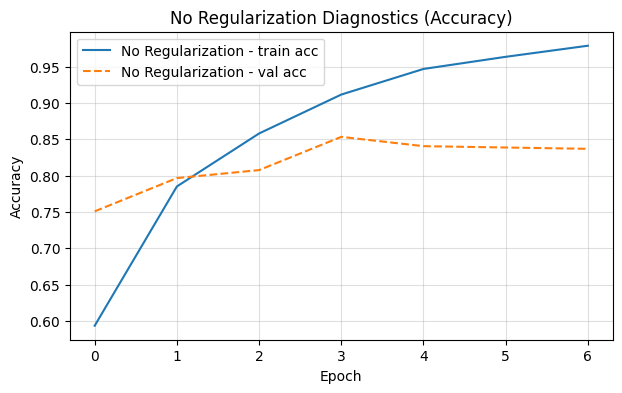

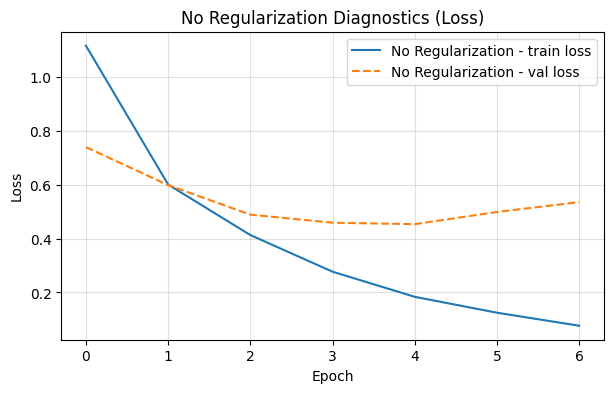

In [44]:
hist, mean_acc_no, test_acc_no = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_no:.4f} | TEST acc={test_acc_no:.4f}")
plot_history({"No Regularization": hist}, title="No Regularization Diagnostics")



L2 Regularization (Weight Decay = 1e-4)

[Final Retrain] Epoch 01: train_acc=0.5909, val_acc=0.7491
[Final Retrain] Epoch 02: train_acc=0.7854, val_acc=0.7912
[Final Retrain] Epoch 03: train_acc=0.8561, val_acc=0.8333
[Final Retrain] Epoch 04: train_acc=0.9050, val_acc=0.8535
[Final Retrain] Epoch 05: train_acc=0.9480, val_acc=0.8462
[Final Retrain] Epoch 06: train_acc=0.9605, val_acc=0.8516
[Final Retrain] Epoch 07: train_acc=0.9741, val_acc=0.8315
[Final Retrain] Early stopping.

Train mean val acc=0.8223 | TEST acc=0.9000


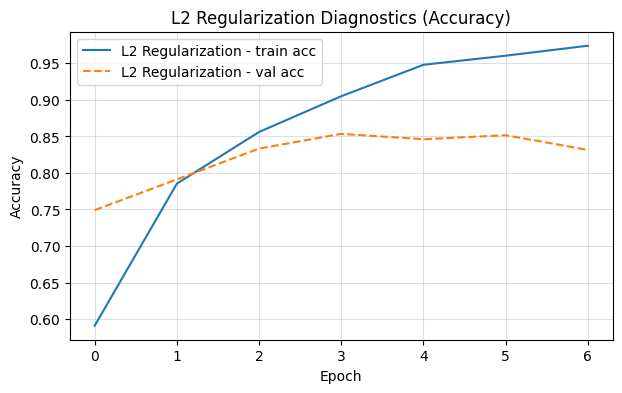

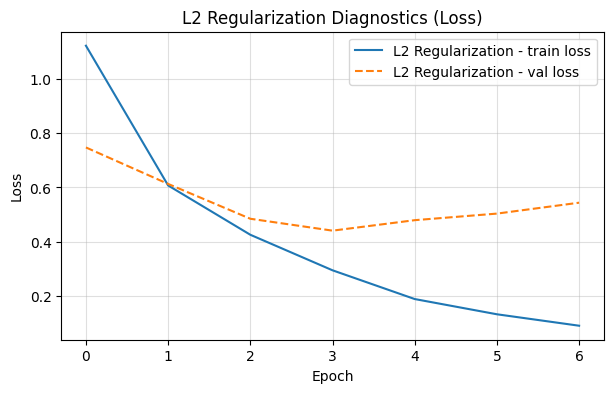

In [45]:
hist, mean_acc_L2, test_acc_L2 = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,     
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_L2:.4f} | TEST acc={test_acc_L2:.4f}")
plot_history({"L2 Regularization": hist}, title="L2 Regularization Diagnostics")


Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5934, val_acc=0.7509
[Final Retrain] Epoch 02: train_acc=0.7823, val_acc=0.7985
[Final Retrain] Epoch 03: train_acc=0.8596, val_acc=0.8077
[Final Retrain] Epoch 04: train_acc=0.9134, val_acc=0.8498
[Final Retrain] Epoch 05: train_acc=0.9468, val_acc=0.8516
[Final Retrain] Epoch 06: train_acc=0.9641, val_acc=0.8462
[Final Retrain] Epoch 07: train_acc=0.9790, val_acc=0.8388
[Final Retrain] Epoch 08: train_acc=0.9904, val_acc=0.8462
[Final Retrain] Early stopping.

Train mean val acc=0.8237 | TEST acc=0.8980


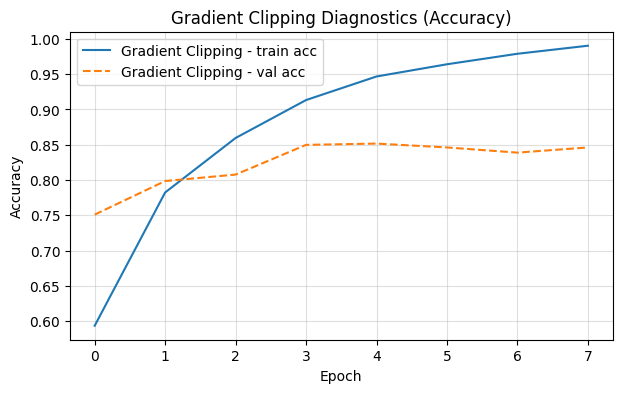

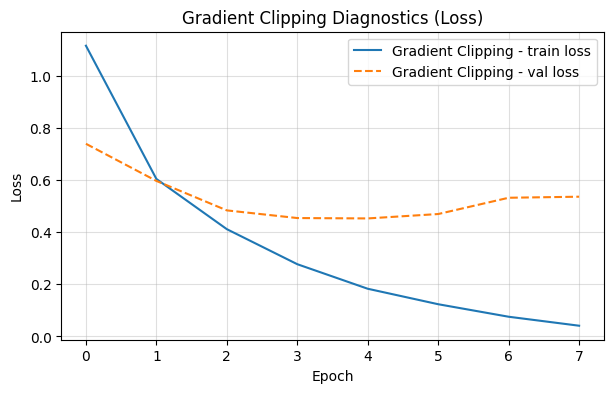

In [46]:
hist, mean_acc_gc, test_acc_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data, 
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_gc:.4f} | TEST acc={test_acc_gc:.4f}")
plot_history({"Gradient Clipping": hist}, title="Gradient Clipping Diagnostics")


L2 Regularization (Weight Decay = 1e-4) + Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5909, val_acc=0.7491
[Final Retrain] Epoch 02: train_acc=0.7801, val_acc=0.7912
[Final Retrain] Epoch 03: train_acc=0.8545, val_acc=0.8114
[Final Retrain] Epoch 04: train_acc=0.8952, val_acc=0.8462
[Final Retrain] Epoch 05: train_acc=0.9446, val_acc=0.8553
[Final Retrain] Epoch 06: train_acc=0.9580, val_acc=0.8480
[Final Retrain] Epoch 07: train_acc=0.9737, val_acc=0.8333
[Final Retrain] Epoch 08: train_acc=0.9882, val_acc=0.8407
[Final Retrain] Early stopping.

Train mean val acc=0.8219 | TEST acc=0.8900


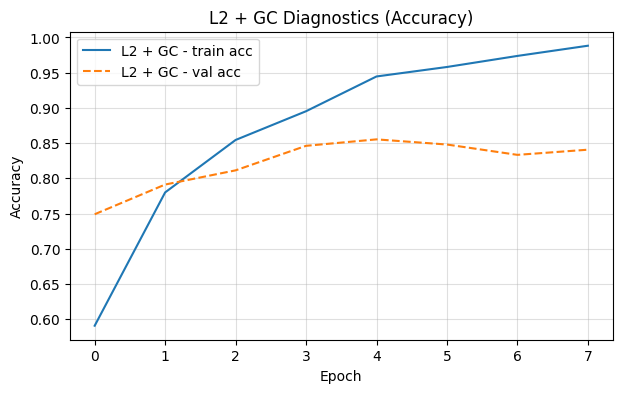

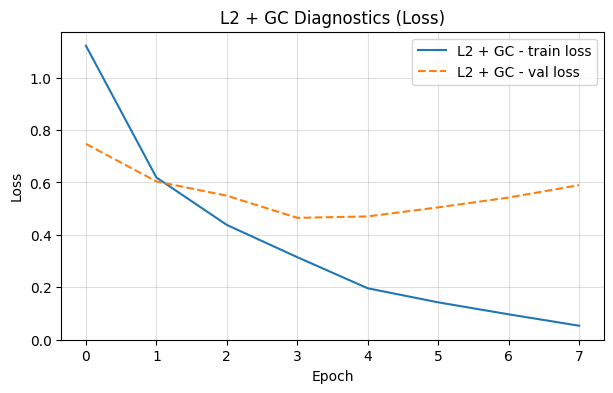

In [47]:
hist, mean_acc_L2_gc, test_acc_L2_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_L2_gc:.4f} | TEST acc={test_acc_L2_gc:.4f}")
plot_history({"L2 + GC": hist}, title="L2 + GC Diagnostics")


In [48]:
acc = [test_acc_no, test_acc_L2, test_acc_gc, test_acc_L2_gc]
name = ["No Reg", "L2 Reg", "GC Reg", "L2+GC Reg"]
clipped_acc = list(zip(name, acc))
sorted_acc = sorted(clipped_acc, key=lambda x: x[1], reverse=True)
print("Final Test Accuracies (sorted):")
for i, a in enumerate(sorted_acc):
    print(f"Rank {i+1}: {a[0]} | {a[1]:.4f}")

Final Test Accuracies (sorted):
Rank 1: L2 Reg | 0.9000
Rank 2: No Reg | 0.8980
Rank 3: GC Reg | 0.8980
Rank 4: L2+GC Reg | 0.8900


Regularization in NLP is a technique to prevent models from overfitting by adding a penalty to the loss function or by constraining the model's complexity, which helps improve its ability to generalize to new, unseen data. 


#### Overall Logical Conclusion

Among the four configurations, L2 regularization achieved the highest test accuracy (0.9000), slightly improving over the baseline (0.8980). This suggests that a small L2 penalty helped prevent minor overfitting by discouraging overly large weights while still allowing the model to learn useful patterns.

Gradient clipping, on the other hand, showed no improvement (0.8980) because the model was already well-behaved — its gradients were stable, and performance was near optimal. Hence, clipping provided little additional benefit.

When L2 and gradient clipping were applied together (0.8900), performance dropped, indicating underfitting. The combined constraints likely restricted the model’s learning capacity too much.

Overall, the results show that this RNN model was already close to its optimal performance without regularization, and while L2 brought a slight stability gain, stronger oregularization made the model too cautious in which it couldn’t learn all the usefl pattens.ularization limited its ability to fit the data eregularization made the model too cautious in which it couldn’t learn all the useful patterns.ffectively. better.

### Q2(c) -- best is L2 Regularization

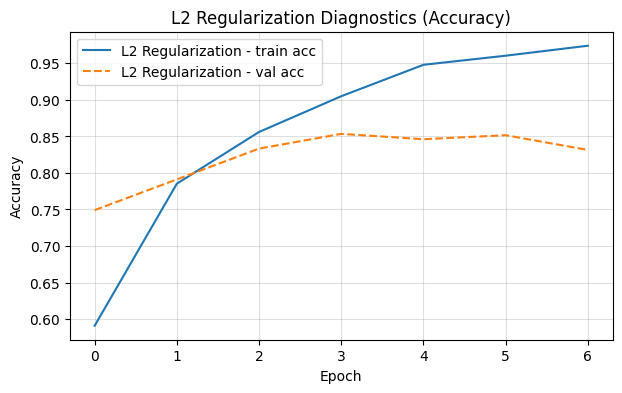

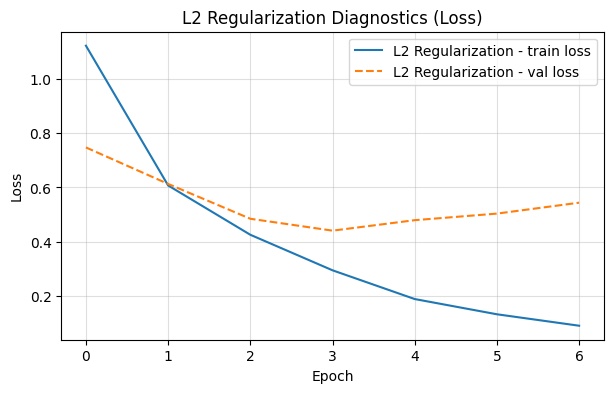

Plot of L2-Regularization curves (the best model):

- Fast early learning. Train accuracy jumps quickly in the first few epochs → features/architecture fit the task well and the LR is reasonable.

- Diminishing returns. After epoch 3–4 the training curve flattens (approaches 1.0) → the model has mostly saturated capacity on the train set.

- Slight overfitting: The validation accuracy goes up until about epoch 4, then stops improving while the validation loss starts to increase a little. This shows the model is starting to learn small details from the training data that don’t help on new data (overfit).

- Stable training: The train loss keeps going down smoothly without sudden jumps, meaning the learning process is steady and gradients are stable.


In short: the model learns fast, then lightly overfits; early stopping at the peak val epoch is the right move, and extra regularization isn’t needed here.

### Q2(d)

In [49]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)
full_dataset = train_data
test_dataset = test_data
retrain_val_ratio=0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

RNN model that supports 3 methods (above we only used last method)

In [50]:
# Simple RNN classifier (tanh)  — now with pooling (default='last')
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional, dropout, num_classes, pooling="last"):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)

        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",      # simple RNN
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

        assert pooling in ["last", "avg", "max"]
        self.pooling = pooling

    def forward(self, text):
        x = self.embedding(text)                     # [B, T, E]
        outputs, hidden = self.rnn(x)                # outputs: [B, T, H*dirs], hidden: [L*D, B, H]

        if self.pooling == "last":
            # IDENTICAL to your original baseline: last hidden state(s)
            if self.rnn.bidirectional:
                rep = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]
            else:
                rep = hidden[-1]                                   # [B, H]

        elif self.pooling == "avg":
            rep = outputs.mean(dim=1)  # [B, H*dirs]

        elif self.pooling == "max":
            rep, _ = torch.max(outputs, dim=1)  # [B, H*dirs]

        return self.fc(self.dropout(rep))


In [51]:
def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device, pooling="last"):
    # IMPORTANT: keep the SAME embedding init source as baseline:
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes,
        pooling=pooling               # <- new
    ).to(device)
    return model


In [52]:
def choose_pooling(batch_size, lr, hidden_dim, *,
                   num_layers, bidirectional, dropout, num_classes,
                   full_dataset, pad_idx, device, embedding_layer,
                   test_dataset, # pass test_data here
                   max_epochs=20, patience=3, seed=42,
                   weight_decay=None, clip_value=None, # Off L2 + GC knobs
                   pooling):   

    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:  # gradient clipping here
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    _set_seed(seed)

    # Final retrain on FULL training set
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device, pooling=pooling)
    criterion = nn.CrossEntropyLoss()
    if weight_decay is None:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val_acc, no_improve = None, -1.0, 0

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    mean_acc = float(np.mean(hist["val_acc"]))

    # Evaluate once on TEST set
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = _evaluate(test_iter, final_model, criterion)

    return hist, mean_acc, float(test_acc)


In [53]:
# Plot function
def plot_history(histories, title="Learning Curves"):
    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} - train acc")
        plt.plot(h["val_acc"],   label=f"{name} - val acc", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " (Accuracy)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} - train loss")
        plt.plot(h["val_loss"],   label=f"{name} - val loss", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title + " (Loss)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()


Using Last Hidden State

[Final Retrain] Epoch 01: train_acc=0.5909, val_acc=0.7491
[Final Retrain] Epoch 02: train_acc=0.7854, val_acc=0.7912
[Final Retrain] Epoch 03: train_acc=0.8561, val_acc=0.8333
[Final Retrain] Epoch 04: train_acc=0.9050, val_acc=0.8535
[Final Retrain] Epoch 05: train_acc=0.9480, val_acc=0.8462
[Final Retrain] Epoch 06: train_acc=0.9605, val_acc=0.8516
[Final Retrain] Epoch 07: train_acc=0.9741, val_acc=0.8315
[Final Retrain] Early stopping.

Train mean val acc=0.8223 | TEST acc=0.9000


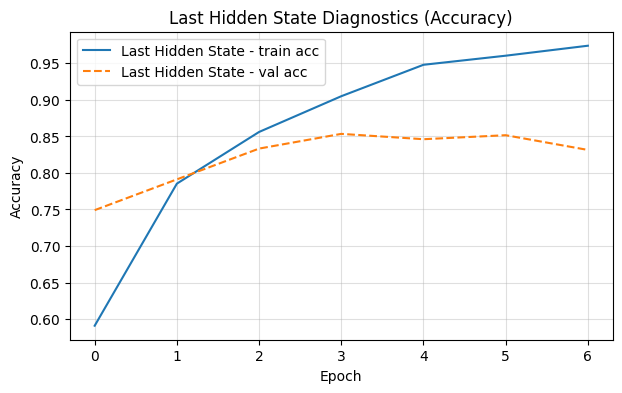

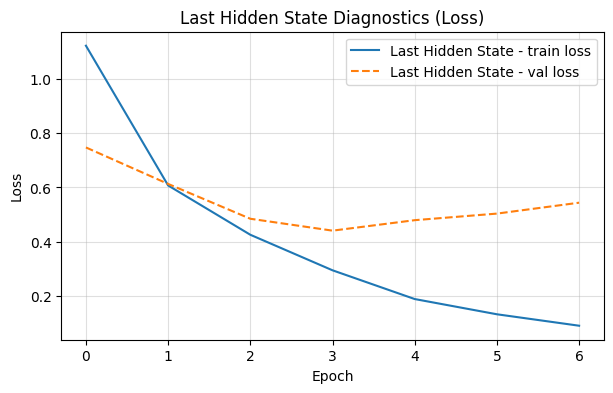

In [58]:
hist, mean_acc_last, test_acc_last = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None, # no GC
    pooling="last"
)
print(f"\nTrain mean val acc={mean_acc_last:.4f} | TEST acc={test_acc_last:.4f}")
plot_history({"Last Hidden State": hist}, title="Last Hidden State Diagnostics")

Using Average Pooling

[Final Retrain] Epoch 01: train_acc=0.3108, val_acc=0.3187
[Final Retrain] Epoch 02: train_acc=0.3903, val_acc=0.5623
[Final Retrain] Epoch 03: train_acc=0.4812, val_acc=0.4615
[Final Retrain] Epoch 04: train_acc=0.5320, val_acc=0.5348
[Final Retrain] Epoch 05: train_acc=0.6498, val_acc=0.6026
[Final Retrain] Epoch 06: train_acc=0.7042, val_acc=0.6868
[Final Retrain] Epoch 07: train_acc=0.7988, val_acc=0.6996
[Final Retrain] Epoch 08: train_acc=0.8453, val_acc=0.6996
[Final Retrain] Epoch 09: train_acc=0.8804, val_acc=0.6740
[Final Retrain] Epoch 10: train_acc=0.9040, val_acc=0.6026
[Final Retrain] Early stopping.

Train mean val acc=0.5842 | TEST acc=0.7480


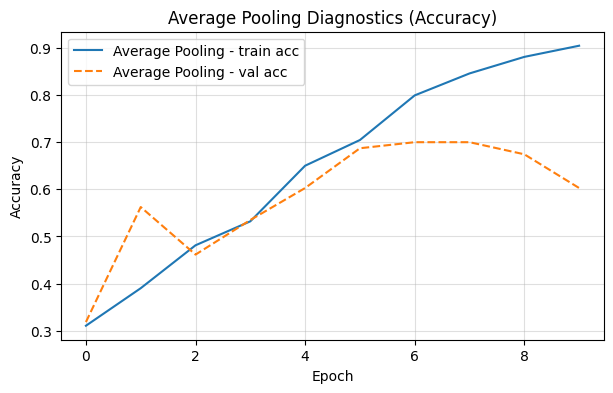

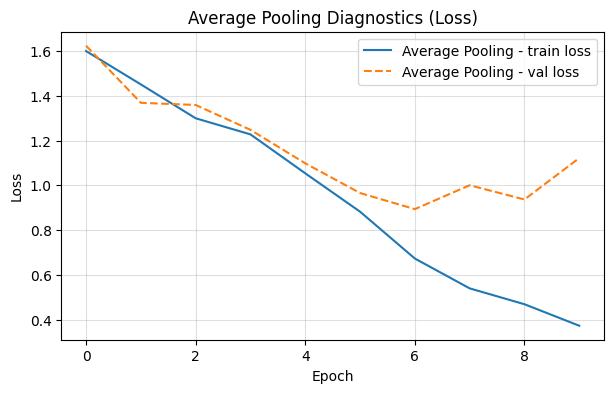

In [59]:
hist, mean_acc_avg, test_acc_avg = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None, # GC
    pooling="avg"
)
print(f"\nTrain mean val acc={mean_acc_avg:.4f} | TEST acc={test_acc_avg:.4f}")
plot_history({"Average Pooling": hist}, title="Average Pooling Diagnostics")

Using Maximum Pooling

[Final Retrain] Epoch 01: train_acc=0.4719, val_acc=0.5568
[Final Retrain] Epoch 02: train_acc=0.7305, val_acc=0.7894
[Final Retrain] Epoch 03: train_acc=0.8261, val_acc=0.8352
[Final Retrain] Epoch 04: train_acc=0.8734, val_acc=0.8480
[Final Retrain] Epoch 05: train_acc=0.9156, val_acc=0.8681
[Final Retrain] Epoch 06: train_acc=0.9486, val_acc=0.8571
[Final Retrain] Epoch 07: train_acc=0.9700, val_acc=0.8718
[Final Retrain] Epoch 08: train_acc=0.9798, val_acc=0.8864
[Final Retrain] Epoch 09: train_acc=0.9868, val_acc=0.8773
[Final Retrain] Epoch 10: train_acc=0.9904, val_acc=0.8901
[Final Retrain] Epoch 11: train_acc=0.9963, val_acc=0.8736
[Final Retrain] Epoch 12: train_acc=0.9961, val_acc=0.8755
[Final Retrain] Epoch 13: train_acc=0.9949, val_acc=0.8571
[Final Retrain] Early stopping.

Train mean val acc=0.8374 | TEST acc=0.9000


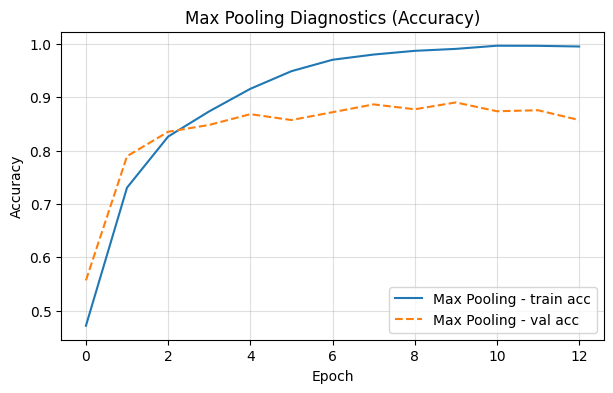

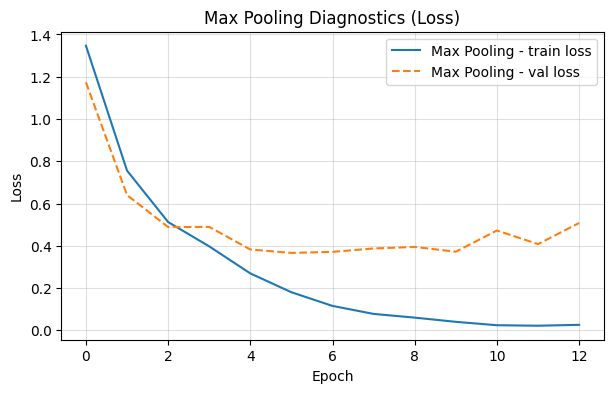

In [60]:
hist, mean_acc_max, test_acc_max = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None, # GC
    pooling="max"
)
print(f"\nTrain mean val acc={mean_acc_max:.4f} | TEST acc={test_acc_max:.4f}")
plot_history({"Max Pooling": hist}, title="Max Pooling Diagnostics")

In [61]:
print("Summary of Test Accuracies:")
print(f"Last Hidden State : {test_acc_last:.4f}")
print(f"Average Pooling   : {test_acc_avg:.4f}")
print(f"Max Pooling       : {test_acc_max:.4f}")


Summary of Test Accuracies:
Last Hidden State : 0.9000
Average Pooling   : 0.7480
Max Pooling       : 0.9000


Both Last Hidden State and Max Pooling achieved the same best test accuracy = 0.9000, can choose either one to proceed? or can rerun using your laptop first, maybe no tie

### Q2(e)

## Click into this markdown for reading


In Q2(e) can call `choose_pooling` function using:

hist, mean_acc, test_acc = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None, # no GC
    pooling="replace with the best pooling method"
)

or modify from the `choose_pooling` function to display the topic-wise accuracy and then call the new modified function 
